<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [8]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [9]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [10]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.99


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

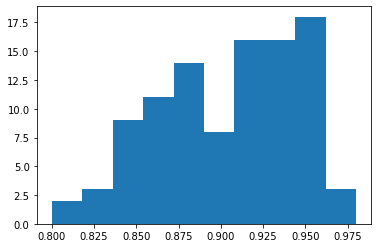

In [11]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

In [13]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
#X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.45


Feature Selection: Even if the targets are independent of the features, if you perform feature selection without considering this independence, the selected features might accidentally appear to have a relationship with the target due to chance. By randomly selecting features without applying any feature selection methods, you're more likely to observe a closer accuracy score to the expected 50% when the targets are truly independent of the features. 

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
``` 

In [ ]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

In [57]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train (1).csv", index_col='PassengerId')

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def feature_selection_and_preprocessing(dataset):
  features = dataset[["Fare", "Parch", 'Age', 'Sex' ,'SibSp']].copy()
  features["Fare"] /= features["Fare"].mean()
  features["Age"] = features["Age"].fillna(features["Age"].median())
  features.Sex.replace(['male', 'female'], [1,0], inplace=True)

  features['Fare'] *= 1
  return features

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_selection_and_preprocessing(data.drop('Survived', axis=1)), data['Survived'], test_size=100, random_state=42)

In [61]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# our model
model = KNeighborsClassifier()
# StratifiedKFold validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [62]:
# generate set pf params for model 
k_range = list(range(1, 31))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [63]:
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [64]:
# perform GridSearchCV with StratifiedKFold validation
clf = GridSearchCV(model, param_grid,scoring='roc_auc', cv=skf)
clf.fit(X,y)
print('Best roc-auc score: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc-auc score: 0.5141, with best C: {'n_neighbors': 9}


In [65]:
# biult model with the best param
model_best = KNeighborsClassifier(
    n_neighbors=clf.best_params_['n_neighbors']
)

In [66]:
model_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [67]:
test_predictions = model_best.predict(X_test)

In [68]:
print("Test accuracy:", accuracy_score(
    y_test,
    test_predictions
))

Test accuracy: 0.75


In previous homework i achieved accuracy that was equal to 53%. Now my model KNeighborsClassifier(n_neighbors=9) has accuracy 75%. The result is much more better!